# Final Result use Maxabs scaling

# MaxAbsScaler

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import glob
import joblib
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [2]:
# Define file paths for each folder
folder_paths = {
    "I": r"./Training/aventa_rotor_icing_excel files/**/*.csv",
    "P": r"./Training/aventa_failure_flexible_coupling_of_collective_pitch_drive_excel files/**/*.csv",
    "B": r"./Training/aventa_blade_aerodynamic_imbalance_excel files/**/*.csv",
    "N": r"./Training/aventa_normal_operation_for_system_identification/**/*.csv"
}
# Initialize an empty list to store each folder's data
data_list = []
print("Here are the files used for training the model:")

# Loop through each folder path and load all CSVs with the corresponding event label
for event, path in folder_paths.items():
    file_paths = glob.glob(path)  # Use glob to get all .csv files in the folder
    for file_path in file_paths:
        print(f"{file_path}")
        data = pd.read_csv(file_path)
        data = data.sort_values(by="time", ascending=True).reset_index(drop=True)
        
        # Perform forward fill
        data.ffill(inplace=True)
        
        # Label the data with the event type
        data["Event"] = event
        data_list.append(data)

# Combine all loaded data
data = pd.concat(data_list, ignore_index=True)

# Remove the "time" and "Event" columns for clustering
X = data.drop(columns=["time","L1_FBSG_01","L1_FBSG_02","combined"], errors="ignore")

print("X:",X.shape)

# Method: Detect extreme values based on the threshold of 99999
threshold = 99999

# Detect rows with extreme values (greater than 99999 or less than -99999) in any column
extreme_values_mask = (X.iloc[:, :33] < -threshold) | (X.iloc[:, :33]  > threshold)

# Count how many rows contain extreme values in any column
extreme_values_count = extreme_values_mask.any(axis=1).sum()

# Output the number of rows with extreme values
print(f"Number of rows with extreme values: {extreme_values_count}")

# Clean data by removing rows with extreme values
X_cleaned = X[(X.iloc[:, :33] >= -threshold).all(axis=1) & (X.iloc[:, :33] <= threshold).all(axis=1)]

# Reindex the data to match the cleaned data
X_cleaned = X.loc[X_cleaned.index]

print("X_cleaned:",X_cleaned.shape)
X_cleaned


# Keep Event column separately for labeling
X_features = X_cleaned.drop(columns=['Event'])

from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
X_features = scaler.fit_transform(X_features)

# Apply KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=50,tol=1e-6)
X_cleaned['Cluster'] = kmeans.fit_predict(X_features)

# Apply PCA with 3 components for 3D plotting
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_features)

# Convert PCA output to DataFrame and add Event labels
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df['Event'] = X_cleaned['Event'].values
pca_df['Cluster'] = X_cleaned['Cluster'].values

# Save the scaler and KMeans model
joblib.dump(scaler, "scaler2.pkl")
joblib.dump(kmeans, "kmeans2.pkl")

Here are the files used for training the model:
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_17_12_2022/Aventa_23_33_08_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_17_12_2022/Aventa_23_13_06_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_17_12_2022/Aventa_23_43_09_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_17_12_2022/Aventa_23_53_10_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_17_12_2022/Aventa_23_23_07_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_09_04_2022/Aventa_00_25_38_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_09_04_2022/Aventa_00_45_40_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_09_04_2022/Aventa_00_05_36_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Taggenberg_09_04_2022/Aventa_00_15_37_combined.csv
./Training/aventa_rotor_icing_excel files/Aventa_Tag

['kmeans2.pkl']

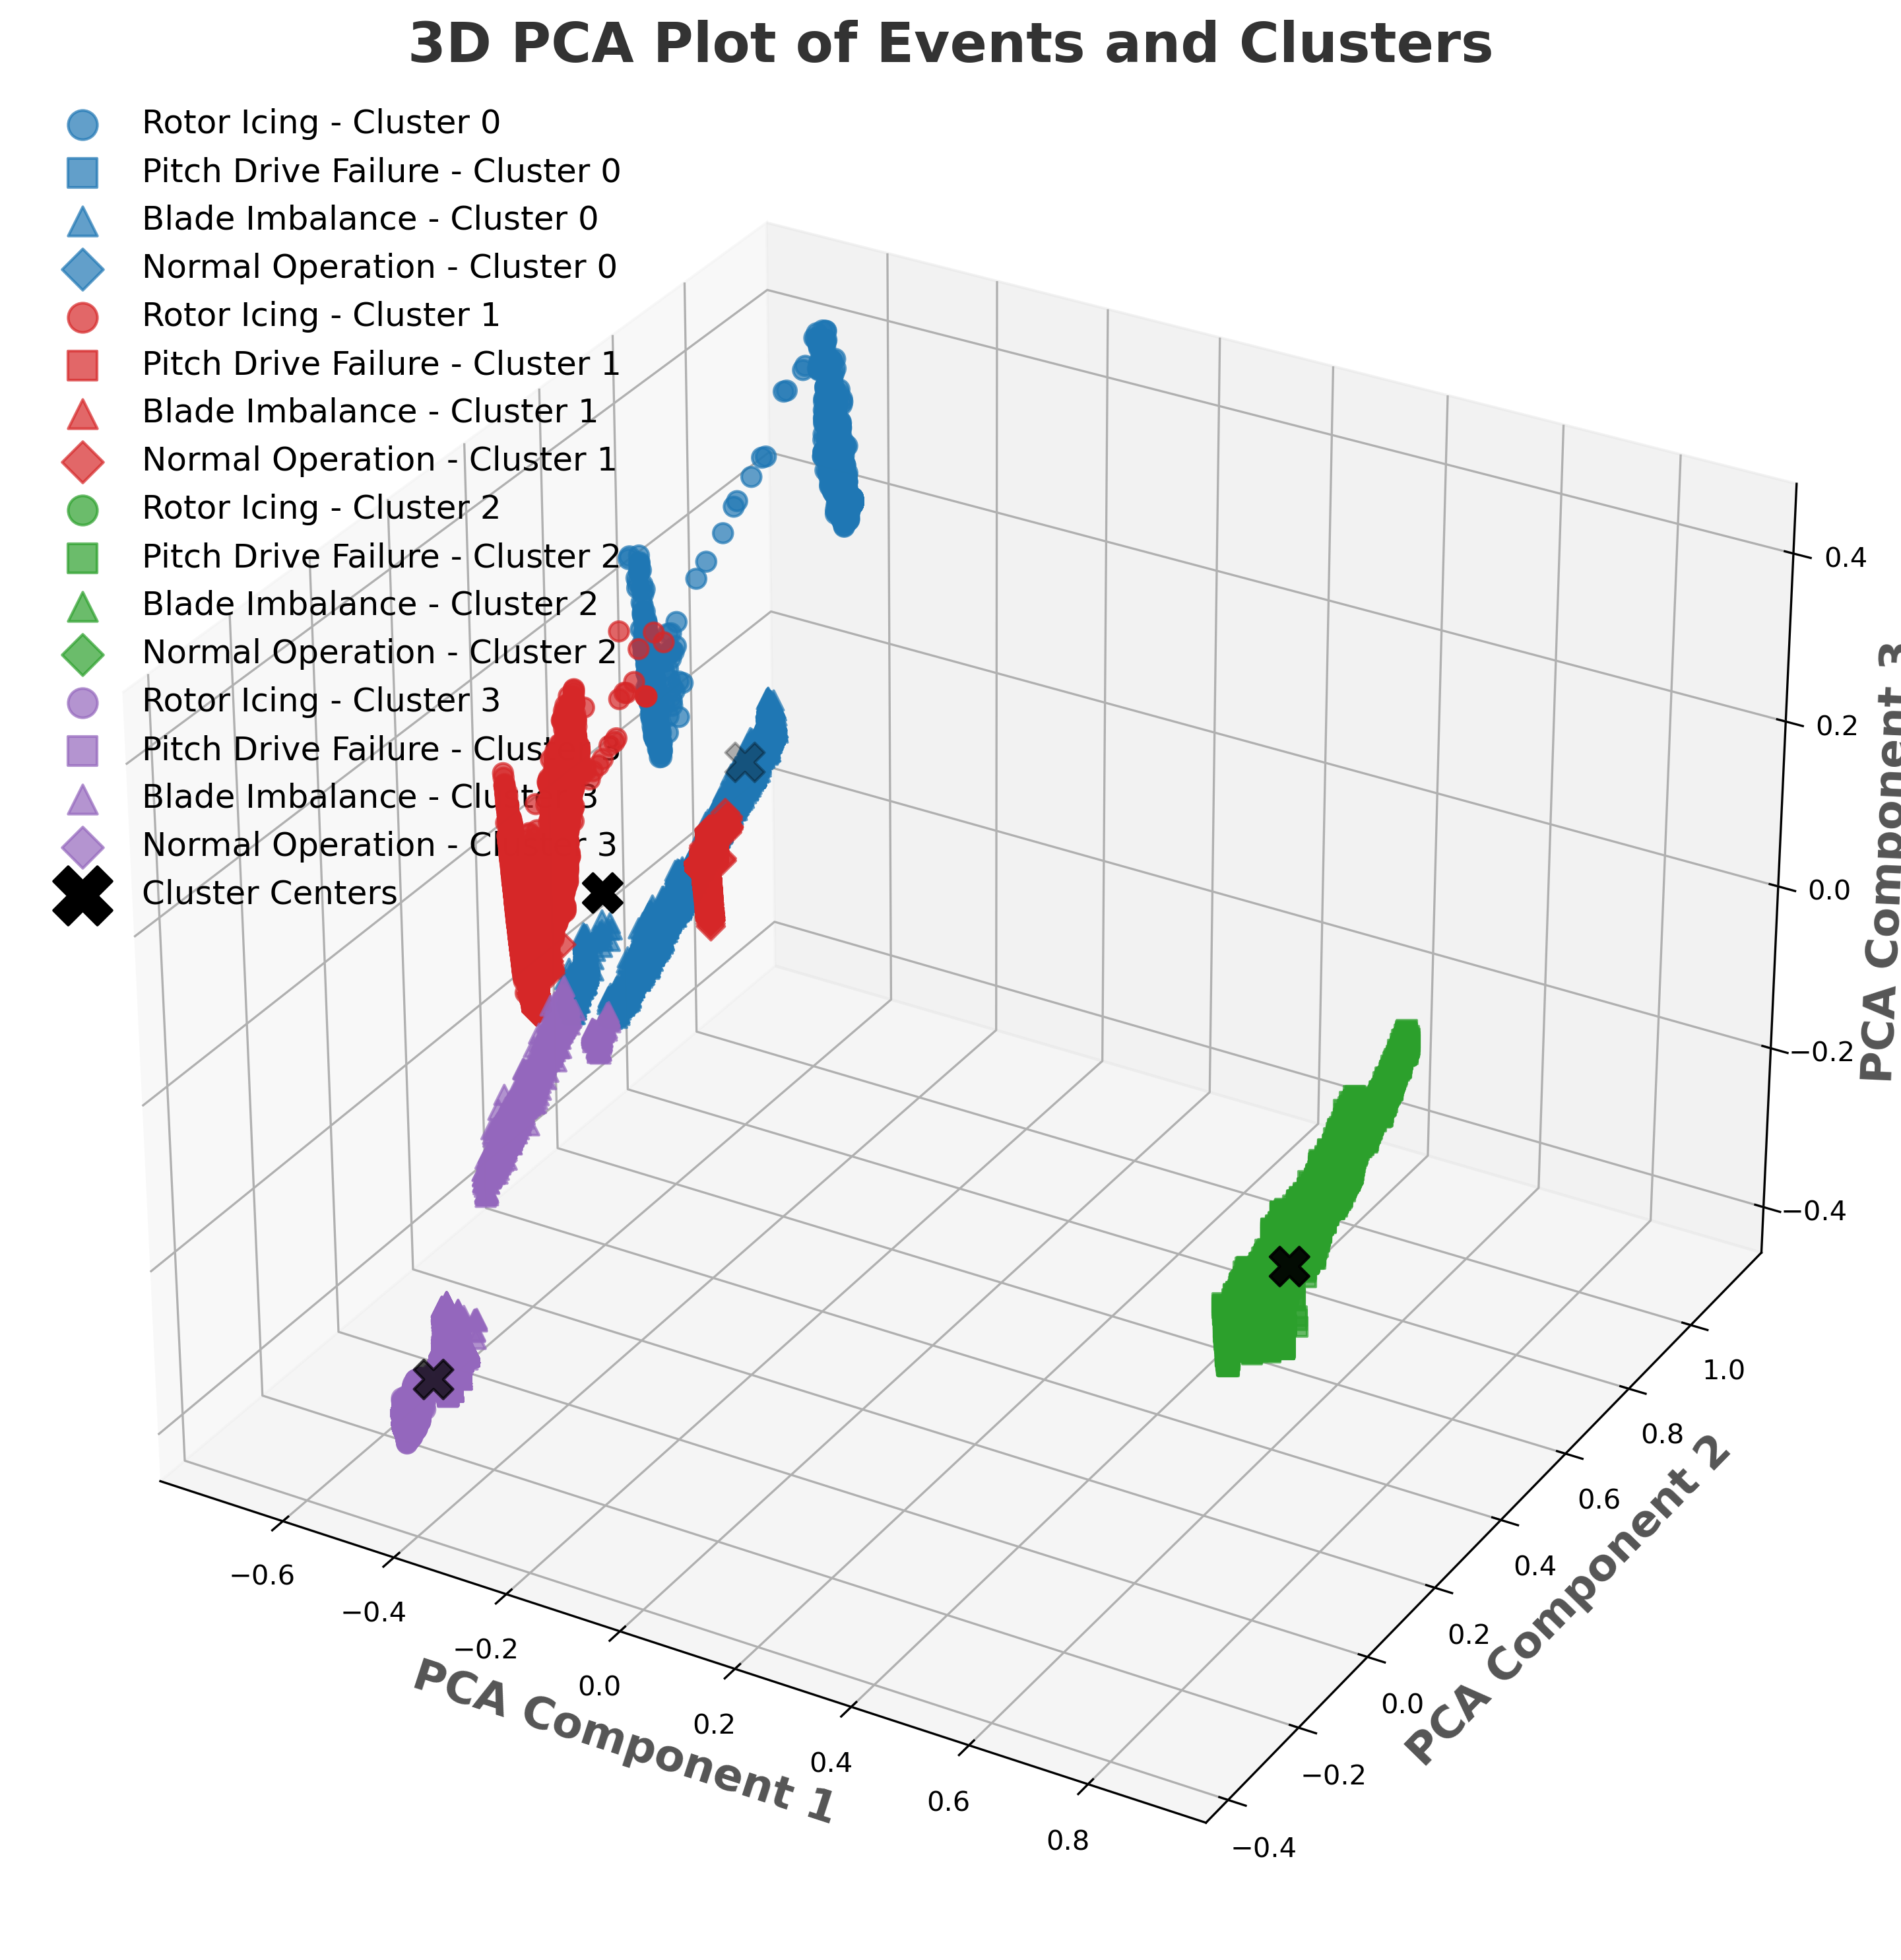

In [3]:
# Define event labels and cluster colors
event_labels = {'I': 'Rotor Icing', 'P': 'Pitch Drive Failure','B': 'Blade Imbalance',  'N': 'Normal Operation'}
cluster_colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd']  # Blue, Purple, Green, Red
cluster_shapes = ['o', 's', '^', 'D']  # Different markers for different clusters

# Plot the PCA-transformed events in 3D
fig = plt.figure(figsize=(12, 10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# Plot each event within the same cluster with refined styles
for cluster in range(4):
    # Filter data for the specific cluster
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    
    # Use the cluster's color for all events in that cluster
    cluster_color = cluster_colors[cluster]
    
    for event, shape in zip(event_labels.keys(), cluster_shapes):
        # Filter data for the specific event within the cluster
        event_data = cluster_data[cluster_data['Event'] == event]
        
        # Select every sample (remove downsampling for better visualization)
        event_data_sampled = event_data.iloc[::1]  # Use all samples for clarity
        
        # Plot the data points for this event, using the cluster's color
        ax.scatter(event_data_sampled['PCA1'], event_data_sampled['PCA2'], event_data_sampled['PCA3'],
                   color=cluster_color, marker=shape, 
                   label=f"{event_labels[event]} - Cluster {cluster}", s=50, alpha=0.7)  # Larger size, alpha for transparency

# Plot cluster centers with a distinctive marker
centers = pca.transform(kmeans.cluster_centers_)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], color='black', marker='X', s=200, label="Cluster Centers")

# Set plot labels and title with improved style
ax.set_title("3D PCA Plot of Events and Clusters", fontsize=20, fontweight='bold', color='#333333')
ax.set_xlabel("PCA Component 1", fontsize=16, fontweight='bold', color='#555555')
ax.set_ylabel("PCA Component 2", fontsize=16, fontweight='bold', color='#555555')
ax.set_zlabel("PCA Component 3", fontsize=16, fontweight='bold', color='#555555')

# Adjust legend to make it clearer and more compact
ax.legend(loc='upper left', fontsize=12, markerscale=1.5, frameon=False)

# Display grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
#plt.show()
plt.savefig('m2t3/3D_Plot.png')


In [4]:
# Dictionary to store the mapping of clusters to event labels
cluster_event_mapping = {}
cluster_event_mapping_event = {}

# List to store each cluster's event percentages
event_percentages_list = []

# Calculate the percentage of each event type within each cluster and store it in a list
for cluster in range(4):  # assuming 4 clusters
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    
    # Count occurrences of each event type within the cluster
    event_counts = cluster_data['Event'].value_counts()
    total_count = event_counts.sum()
    
    # Calculate and store each event's percentage in the cluster
    for event, count in event_counts.items():
        percentage = (count / total_count) * 100
        event_percentages_list.append((percentage, event, cluster))

# Sort all events by percentage in descending order
event_percentages_list.sort(reverse=True, key=lambda x: x[0])

# Set to track events that have already been assigned to a cluster
assigned_events = set()

# Assign the highest percentage event to each cluster if not already assigned
for percentage, event, cluster in event_percentages_list:
    if event not in assigned_events:
        # Assign this event to the cluster
        cluster_event_mapping[cluster] = event  # Use event code as value
        cluster_event_mapping_event[cluster] = event_labels[event]
        assigned_events.add(event)  # Mark this event as assigned

# Print information for each cluster
for cluster in range(4):
    majority_event = cluster_event_mapping.get(cluster)
    majority_event_percentage = next((p for p, e, c in event_percentages_list if e == majority_event and c == cluster), 0)
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    event_counts = cluster_data['Event'].value_counts()
    
    # Print information for each cluster
    print(f"Cluster {cluster}:")
    print(f"  Majority Event: {event_labels[majority_event] if majority_event else 'None'}")
    print(f"  Percentage of Majority Event: {majority_event_percentage:.2f}%")
    print(f"  Event Distribution: {event_counts.to_dict()}")
    print()

# Print the final cluster-event mapping
print("\nFinal Cluster-Event Mapping:")
print(cluster_event_mapping_event)

Cluster 0:
  Majority Event: Blade Imbalance
  Percentage of Majority Event: 81.26%
  Event Distribution: {'B': 414048, 'I': 95505}

Cluster 1:
  Majority Event: Normal Operation
  Percentage of Majority Event: 71.69%
  Event Distribution: {'N': 972933, 'I': 384265}

Cluster 2:
  Majority Event: Pitch Drive Failure
  Percentage of Majority Event: 100.00%
  Event Distribution: {'P': 1202339}

Cluster 3:
  Majority Event: Rotor Icing
  Percentage of Majority Event: 48.39%
  Event Distribution: {'B': 474581, 'I': 444931}


Final Cluster-Event Mapping:
{2: 'Pitch Drive Failure', 0: 'Blade Imbalance', 1: 'Normal Operation', 3: 'Rotor Icing'}


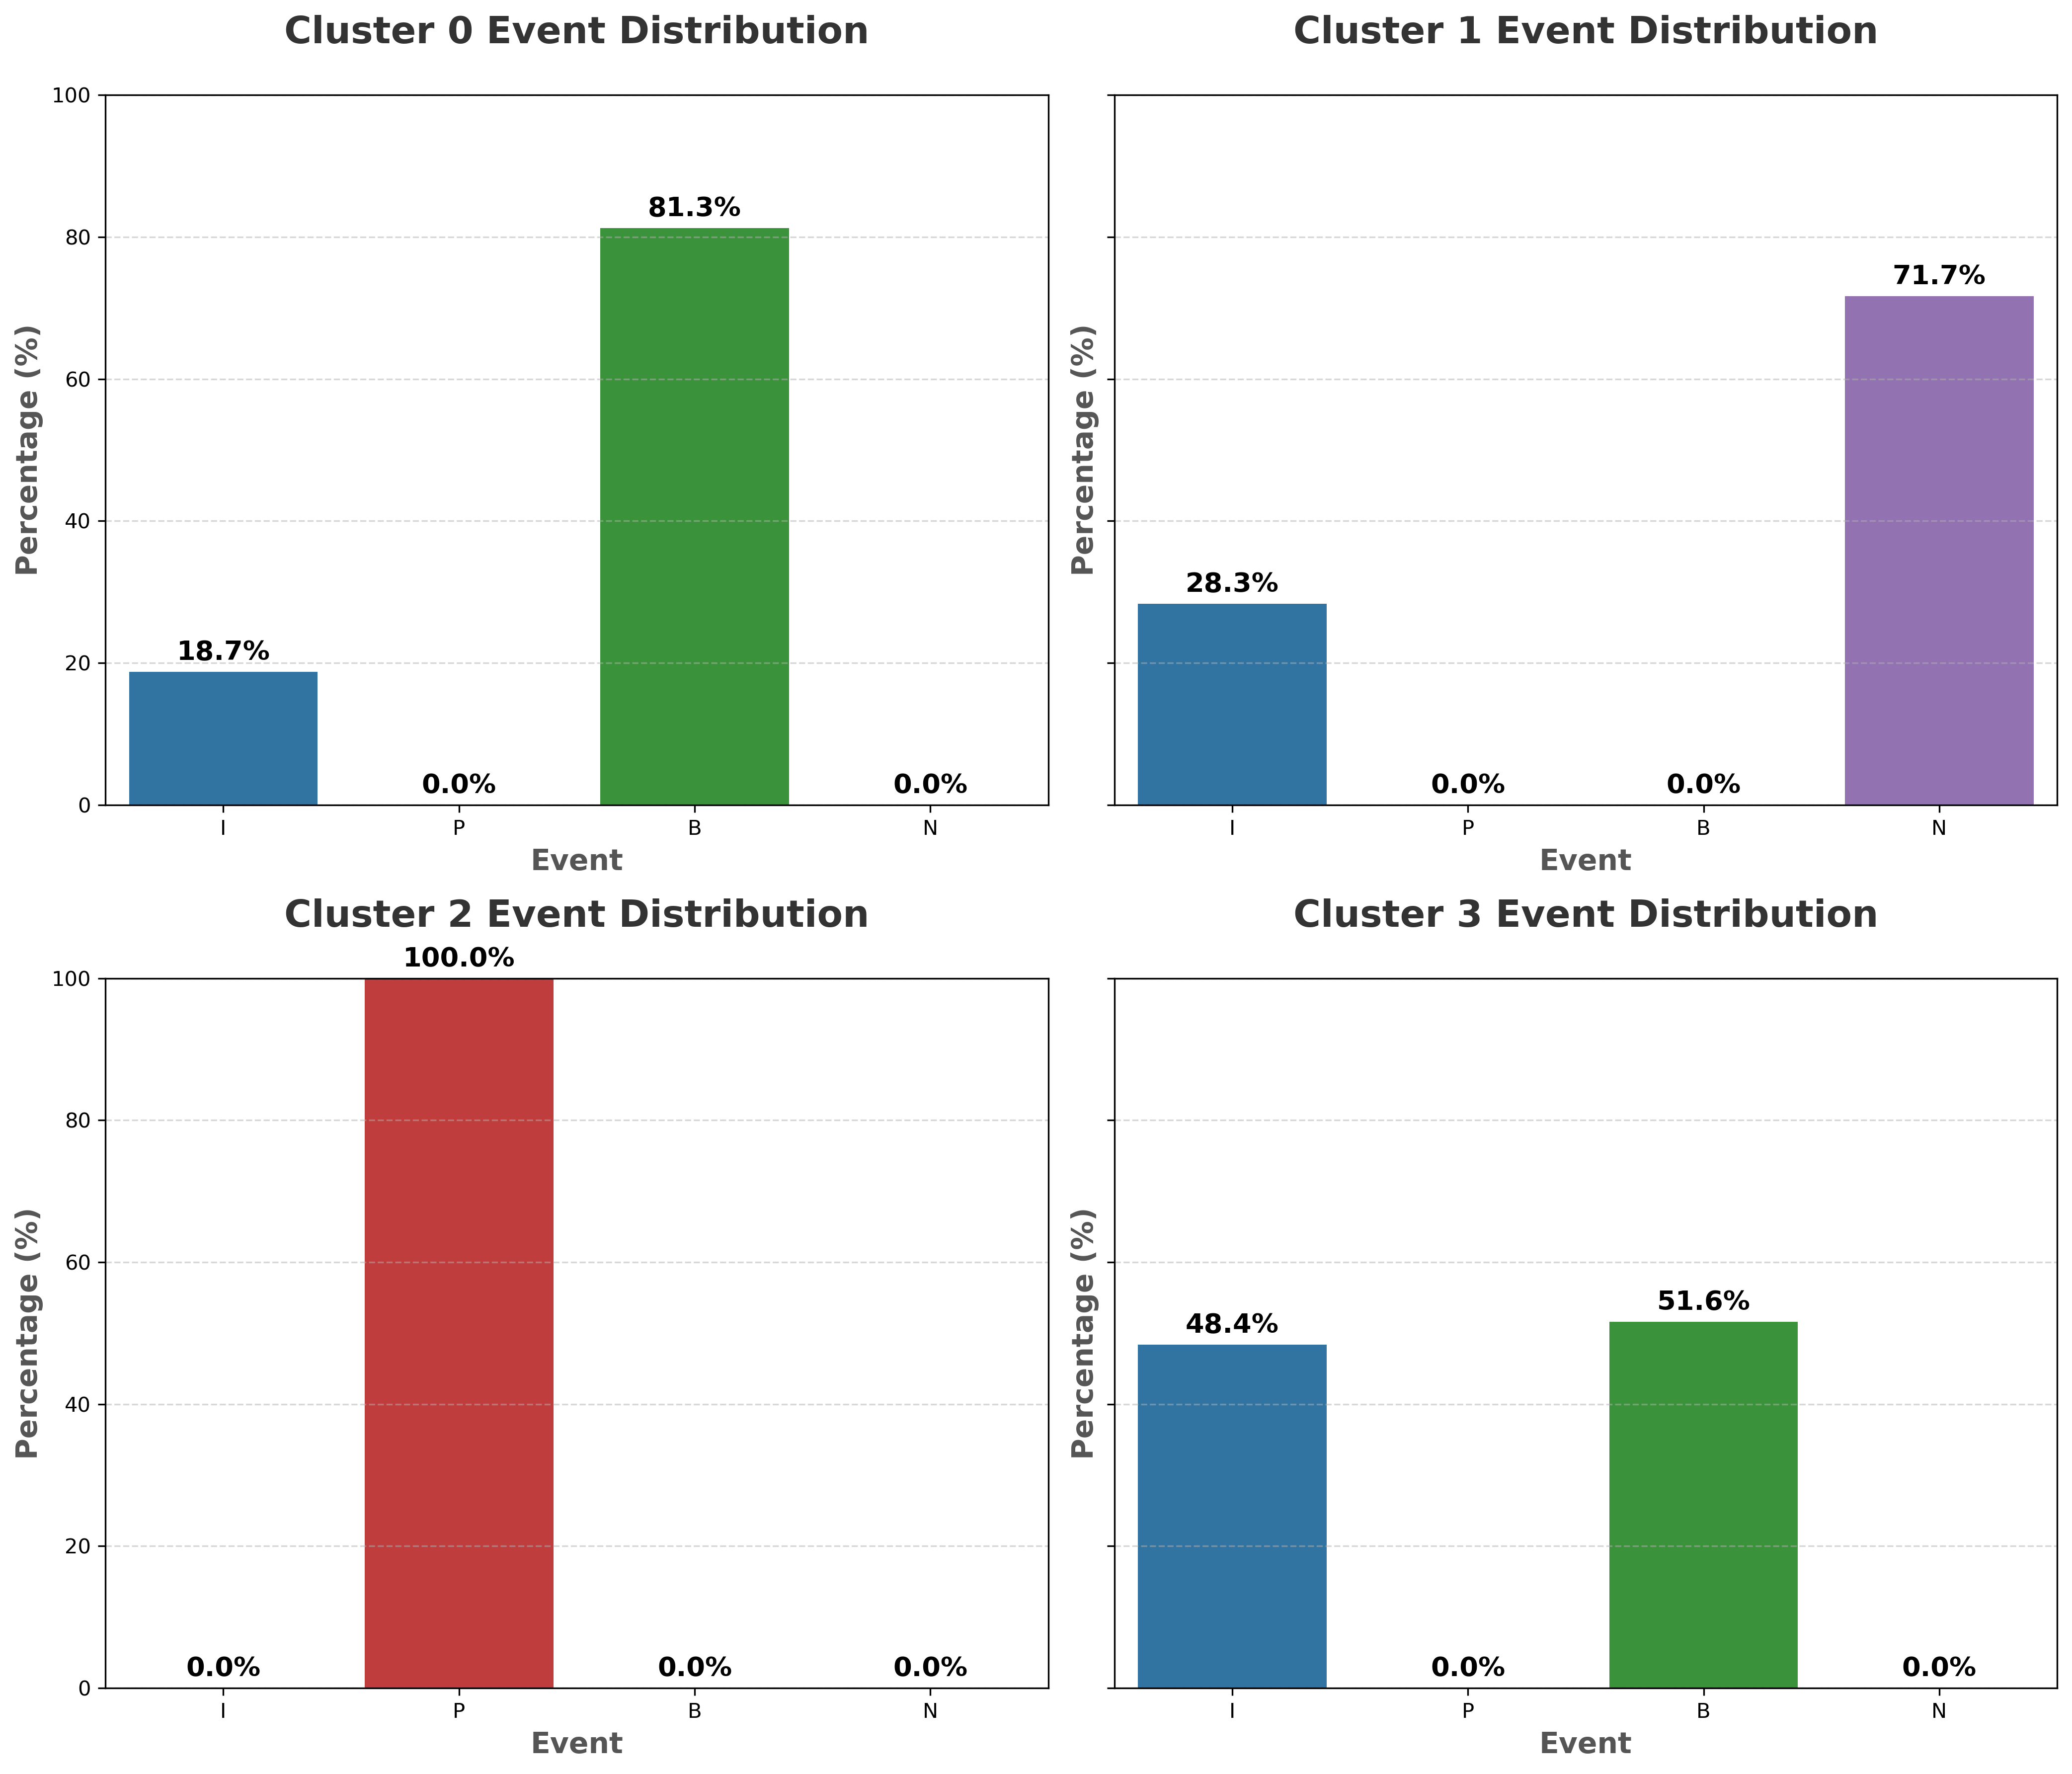

In [5]:
# Define the list of all possible events
all_events = ['I', 'P', 'B', 'N']  # Ensure all events are shown, even if count is 0

# Set up the subplots with a refined figure size
fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True, dpi=300)

# Define a smoother, modern color palette for each event
event_colors = {'I': '#1f77b4', 'N': '#9467bd', 'B': '#2ca02c', 'P': '#d62728'}  # Blue, Purple, Green, Red

for cluster in range(4):
    ax = axes[cluster // 2, cluster % 2]  # Access subplot by row/column
    
    # Filter data for the specific cluster
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    
    # Calculate event percentages and include zero-count events
    event_counts = cluster_data['Event'].value_counts(normalize=True).reindex(all_events, fill_value=0) * 100
    
    # Plot the event distribution for the current cluster with the improved color palette
    sns.barplot(x=event_counts.index, y=event_counts.values, ax=ax, palette=event_colors)
    
    # Title and labels customization with more elegant font
    ax.set_title(f"Cluster {cluster} Event Distribution", fontsize=18, fontweight='bold', pad=25, color='#333333')
    ax.set_xlabel("Event", fontsize=14, fontweight='bold', color='#555555')
    ax.set_ylabel("Percentage (%)", fontsize=14, fontweight='bold', color='#555555')
    
    # Set y-axis limits and a lighter grid for readability
    ax.set_ylim(0, 100)  # Set consistent y-axis limits across subplots
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)  # Subtle horizontal grid lines
    
    # Adding annotations with a contrasting color and stylish font
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom',  # Positioning the annotation above the bar
                    fontsize=13, fontweight='bold',
                    color='black',  # Dark color for visibility
                    xytext=(0, 3), textcoords='offset points')  # Offset closer to the bar

# Tight layout to prevent overlapping and make the spacing look cleaner
plt.tight_layout()

# Show plot
#plt.show()
plt.savefig('m2t3/Event Distribution.png')

In [6]:
# Define test folder paths for each event
test_folder_paths = {
    "I": r"./Test/aventa_rotor_icing_excel files/Aventa_Taggenberg_19_12_2022/*.csv",
    "P": r"./Test/aventa_failure_flexible_coupling_of_collective_pitch_drive_excel files/Aventa_Taggenberg_11_02_2022/*.csv",
    "B": r"./Test/aventa_blade_aerodynamic_imbalance_excel files/aventa_blade_aerodynamic_imbalance Aventa_Taggenberg_21_12_2022/*.csv",
    "N": r"./Test/aventa_normal_operation_for_system_identification_excel files/Aventa_Taggenberg_14_10_2022/*.csv"
}

# Load the saved models
scaler = joblib.load("scaler2.pkl")  # Load scaler if used in training
kmeans = joblib.load("kmeans2.pkl")

# Initialize confusion matrix for the overall result (4x4 for the 4 event types)
conf_matrix_overall = np.zeros((4, 4), dtype=int)

# Initialize lists to store true labels and predicted labels for classification report
y_true_total = []
y_pred_total = []

# Lists to store majority cluster and belief percentages for visualization
majority_clusters = []
belief_percentages = []

# Loop through each test folder, process the files, and compute predictions
for event, path in test_folder_paths.items():
    file_paths = glob.glob(path)
    
    # Process each file in the folder
    for file_path in file_paths:
        print(f"\nProcessing file: {file_path}")

        # Load and preprocess the test data
        data = pd.read_csv(file_path)
        data = data.sort_values(by="time", ascending=True).reset_index(drop=True)
        data.ffill(inplace=True)  # Forward fill for missing values
        data["Event"] = event  # Label data with the event type
        
        # Drop columns used only for training
        X_test = data.drop(columns=["time", "L1_FBSG_01", "L1_FBSG_02", "combined", "Event"], errors="ignore")
        
        # Apply the scaler transformation
        X_test_scaled = scaler.transform(X_test)
        
        # Predict clusters
        cluster_labels = kmeans.predict(X_test_scaled)
        
        # Count how many points fall into each cluster
        cluster_counter = Counter(cluster_labels)
        
        # Find the majority cluster for this file
        majority_cluster, majority_count = cluster_counter.most_common(1)[0]
        
        # Map the predicted cluster to event
        predicted_event = cluster_event_mapping[majority_cluster]
        
        # Calculate majority percentage
        majority_percentage = (majority_count / len(cluster_labels)) * 100
        print(f"Majority cluster: {majority_cluster}")
        print(f"Percentage of points in majority cluster: {majority_percentage:.2f}%")
        
        # Update the confusion matrix for this file
        conf_matrix_overall[["I", "P", "B", "N"].index(event), ["I", "P", "B", "N"].index(predicted_event)] += 1

        # Add true and predicted labels to lists for classification report
        y_true_total.append(event)
        y_pred_total.append(predicted_event)

        
        # Collect data for visualization
        majority_clusters.append(majority_cluster)
        belief_percentages.append(majority_percentage)
        
# Print the confusion matrix for all files
print("\nOverall Confusion Matrix (based on per-file predictions):")
print(conf_matrix_overall)

# Compute overall classification report
overall_report = classification_report(y_true_total, y_pred_total, target_names=["Rotor Icing", "Pitch Drive Failure", "Blade Imbalance", "Normal Operation"], labels=["I", "P", "B", "N"])
print("\nOverall Classification Report:\n", overall_report)

# Overall accuracy score
overall_accuracy = accuracy_score(y_true_total, y_pred_total)
print(f"\nOverall Accuracy: {overall_accuracy:.2f}")


Processing file: ./Test/aventa_rotor_icing_excel files/Aventa_Taggenberg_19_12_2022/Aventa_22_22_59_combined.csv
Majority cluster: 3
Percentage of points in majority cluster: 83.87%

Processing file: ./Test/aventa_rotor_icing_excel files/Aventa_Taggenberg_19_12_2022/Aventa_23_23_05_combined.csv
Majority cluster: 3
Percentage of points in majority cluster: 55.39%

Processing file: ./Test/aventa_rotor_icing_excel files/Aventa_Taggenberg_19_12_2022/Aventa_22_53_02_combined.csv
Majority cluster: 3
Percentage of points in majority cluster: 77.21%

Processing file: ./Test/aventa_rotor_icing_excel files/Aventa_Taggenberg_19_12_2022/Aventa_23_43_07_combined.csv
Majority cluster: 3
Percentage of points in majority cluster: 82.03%

Processing file: ./Test/aventa_rotor_icing_excel files/Aventa_Taggenberg_19_12_2022/Aventa_22_33_00_combined.csv
Majority cluster: 3
Percentage of points in majority cluster: 82.04%

Processing file: ./Test/aventa_rotor_icing_excel files/Aventa_Taggenberg_19_12_2022/

Majority cluster: 1
Percentage of points in majority cluster: 81.70%

Overall Confusion Matrix (based on per-file predictions):
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]

Overall Classification Report:
                      precision    recall  f1-score   support

        Rotor Icing       1.00      1.00      1.00        10
Pitch Drive Failure       1.00      1.00      1.00        10
    Blade Imbalance       1.00      1.00      1.00        10
   Normal Operation       1.00      1.00      1.00        10

           accuracy                           1.00        40
          macro avg       1.00      1.00      1.00        40
       weighted avg       1.00      1.00      1.00        40


Overall Accuracy: 1.00


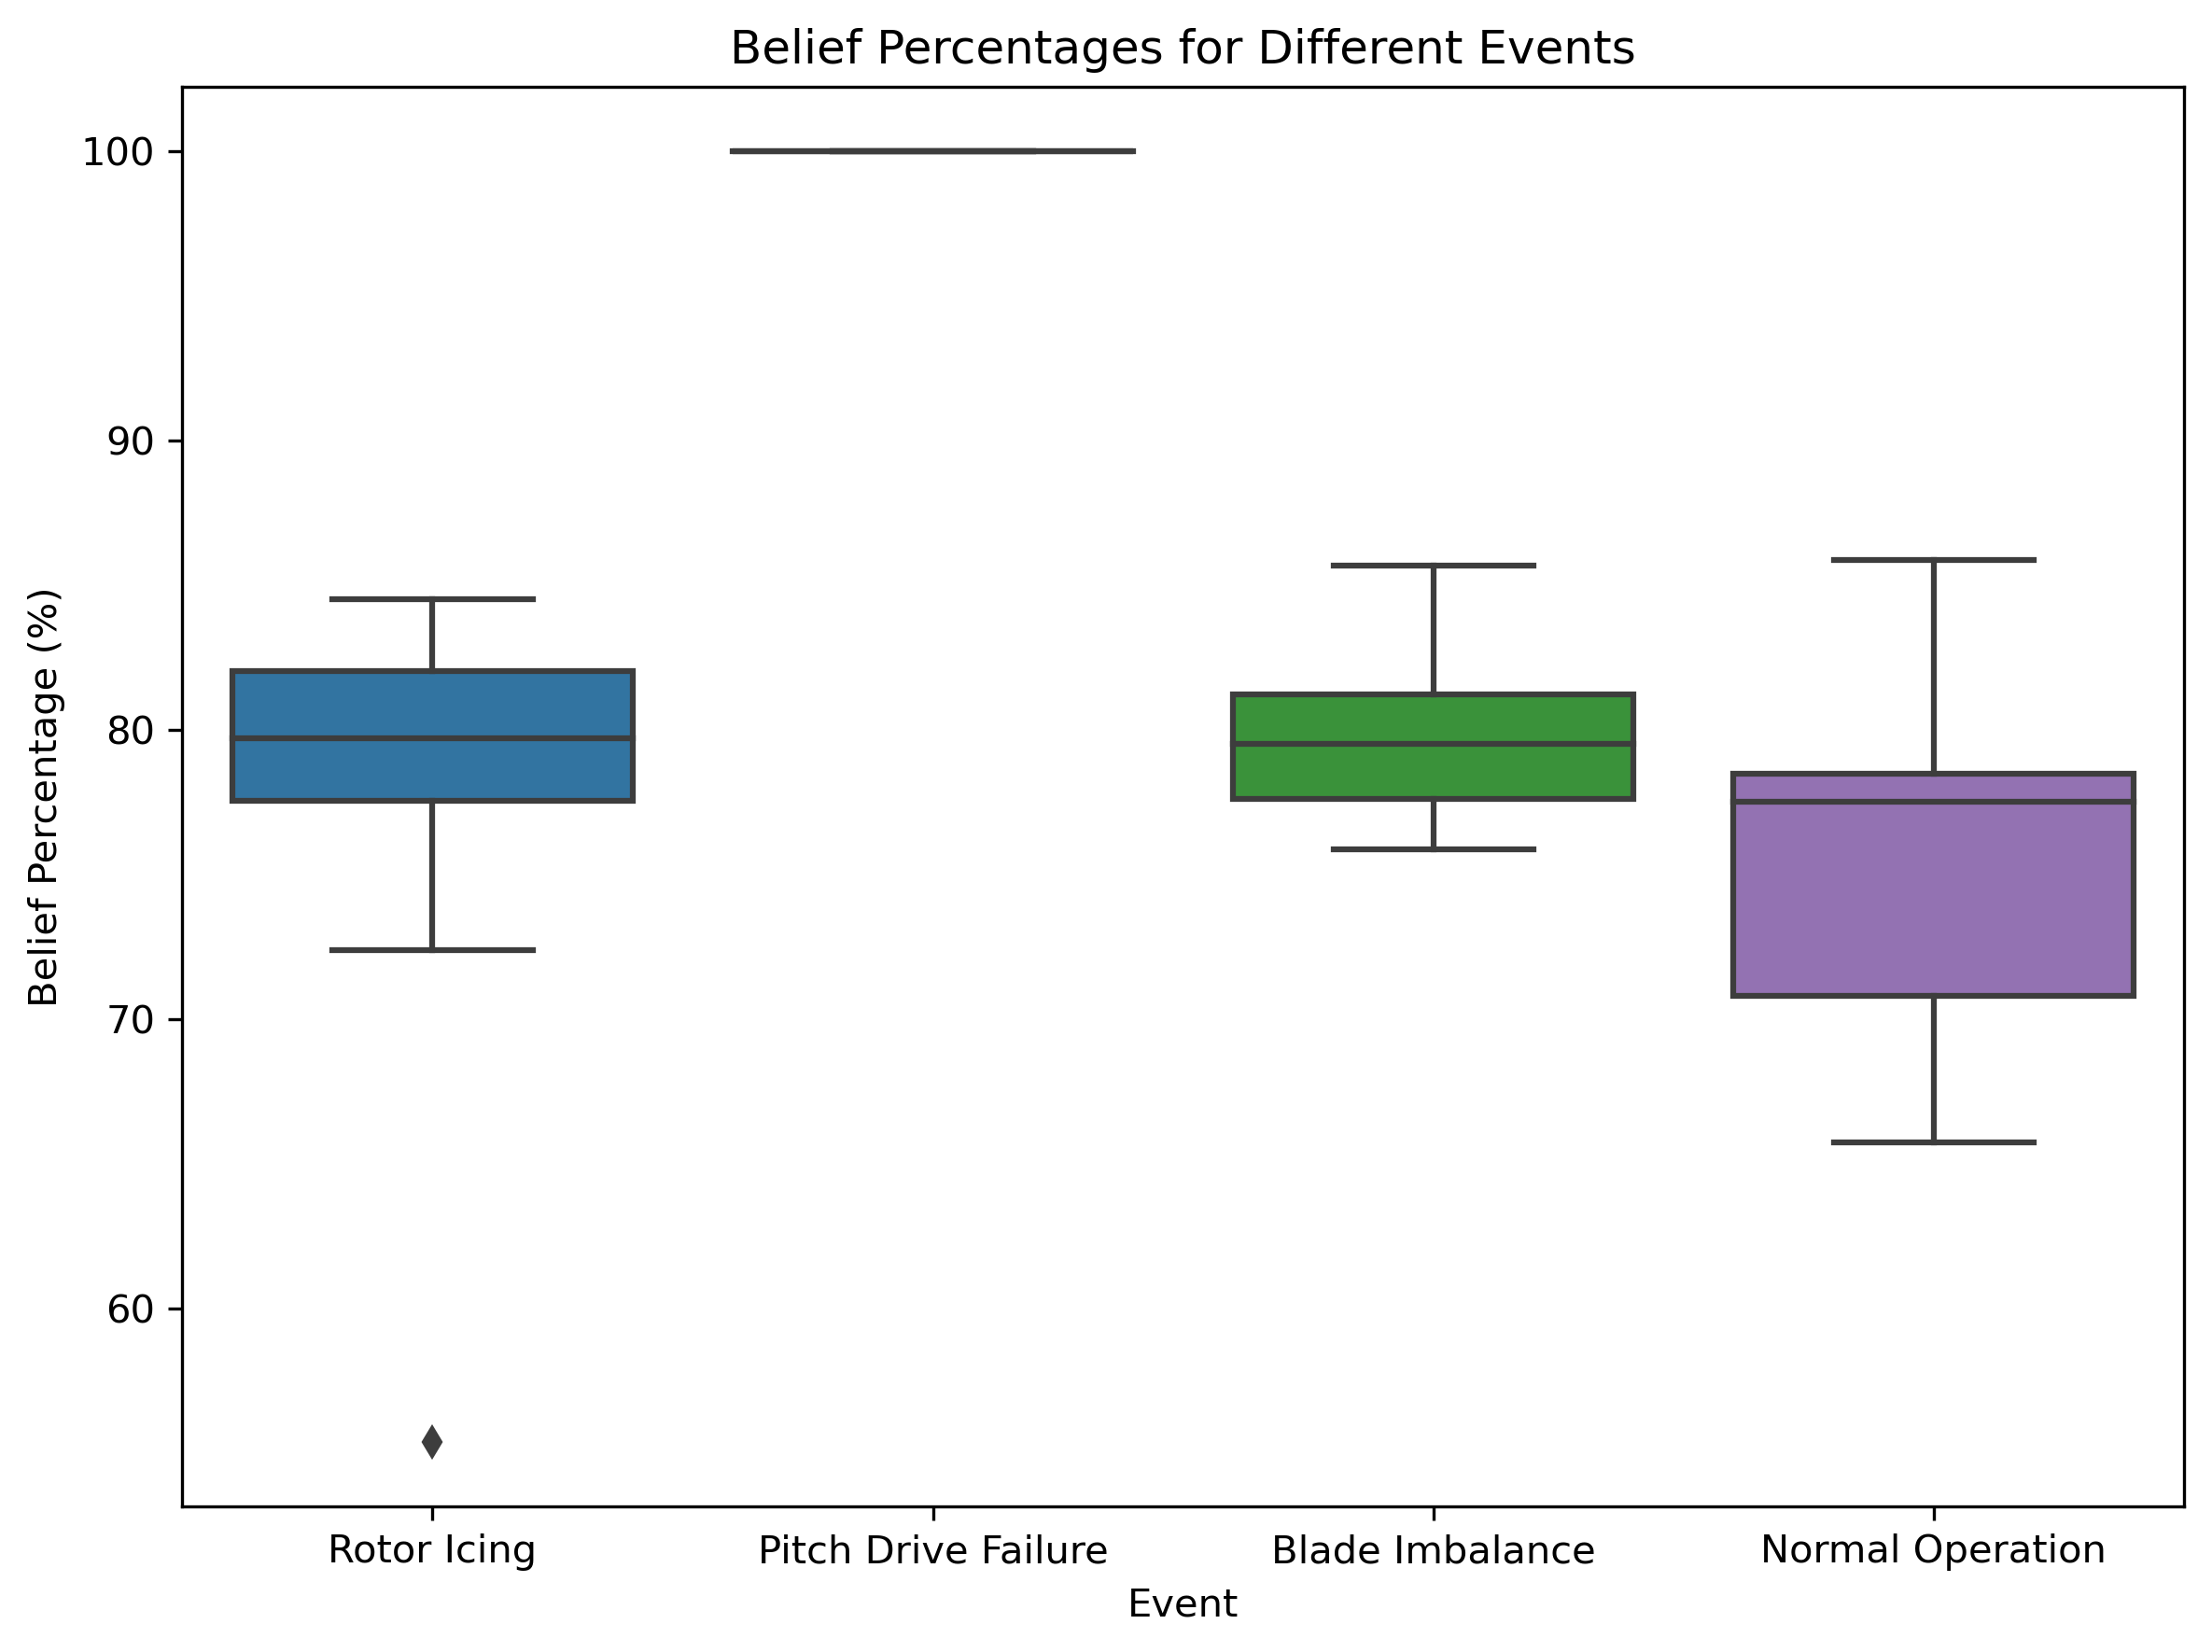

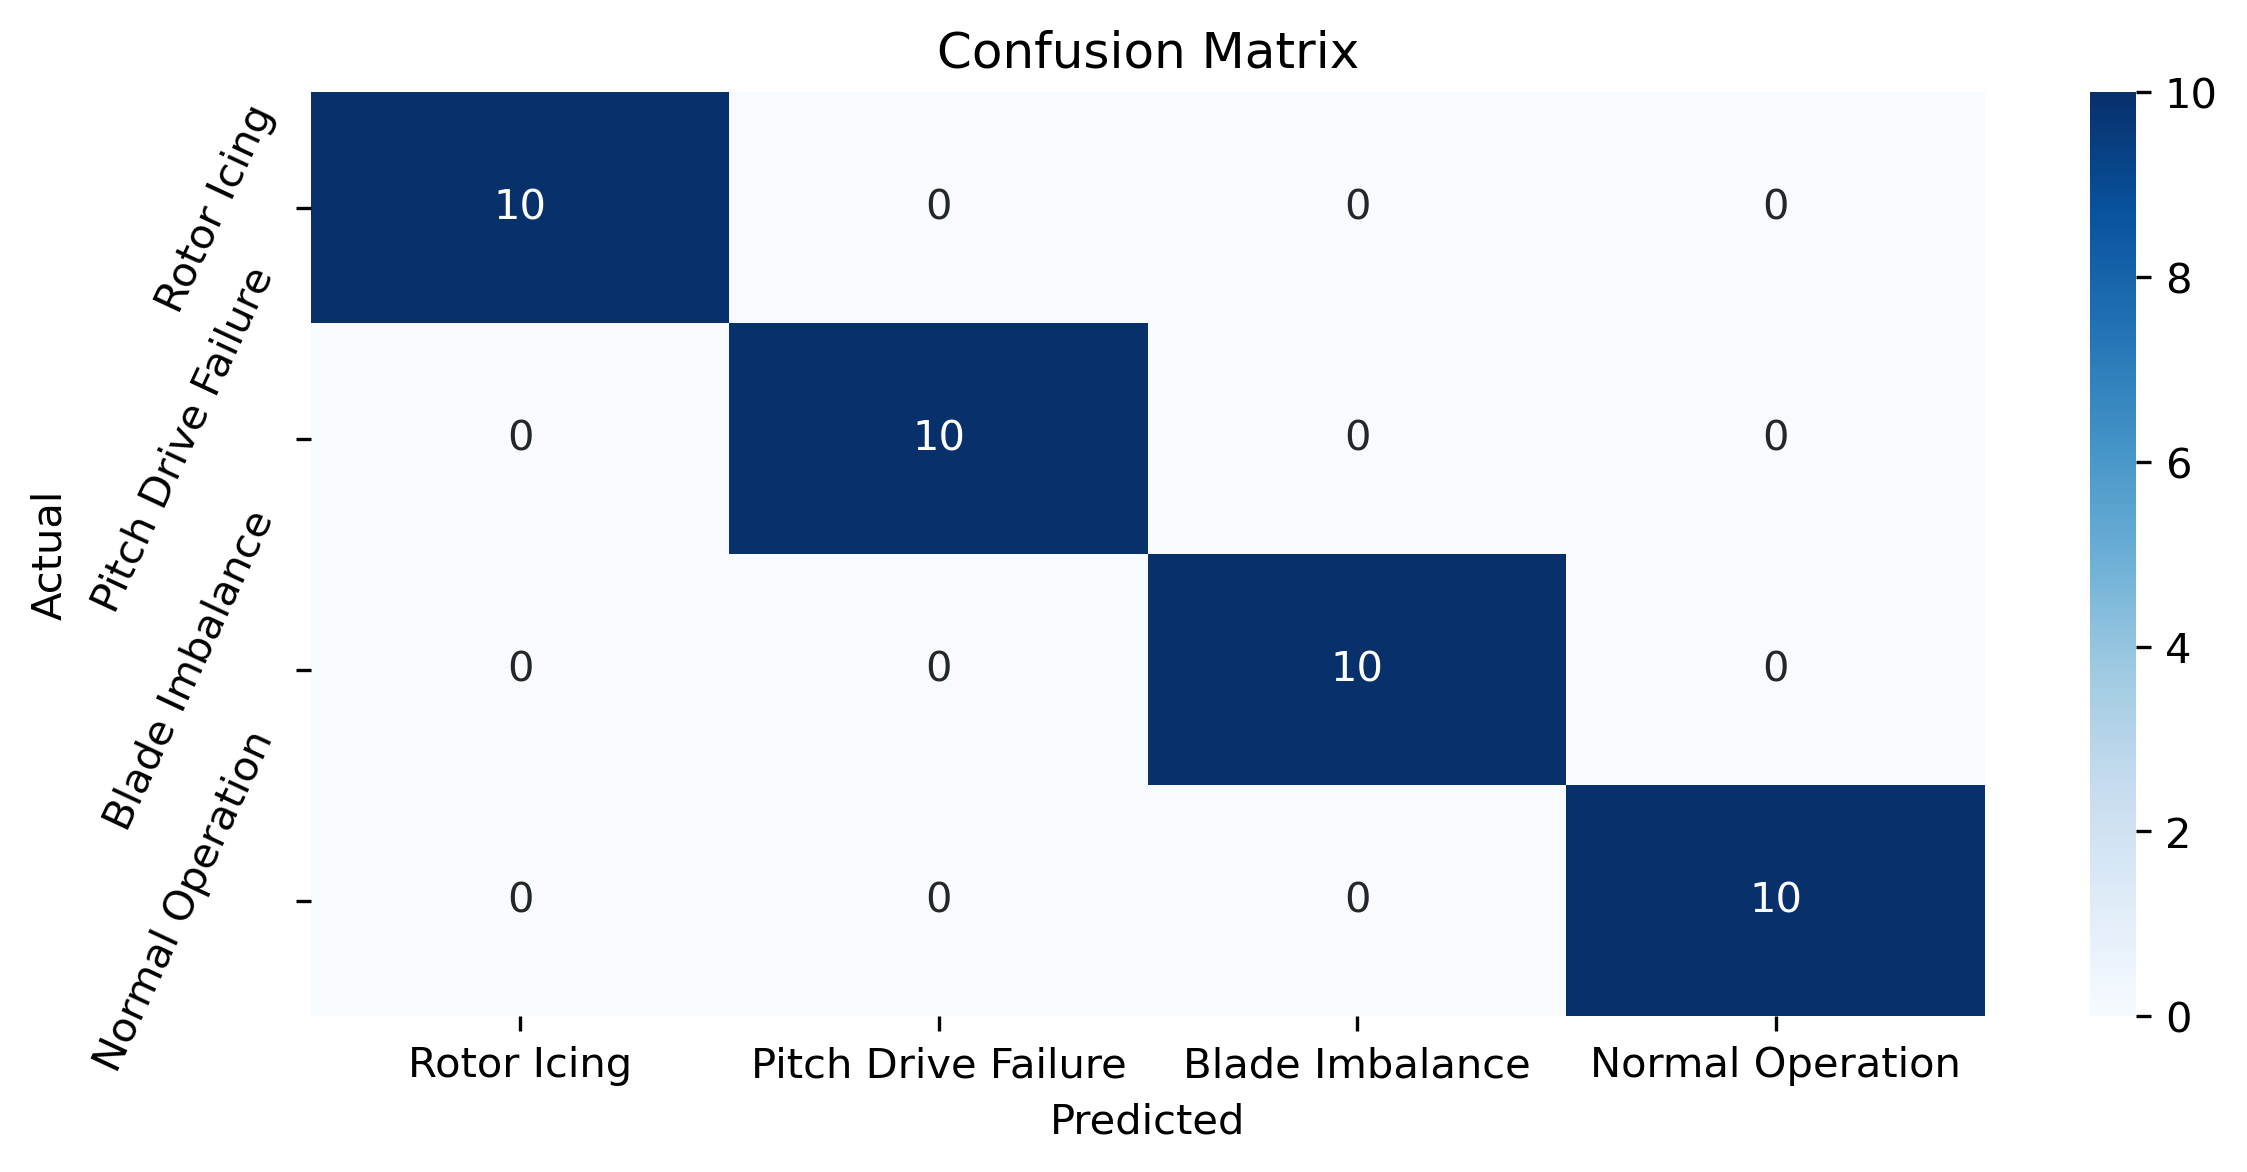

In [7]:
# Map majority cluster to names for labeling
cluster_names = cluster_event_mapping_event

# Custom color palette
custom_palette = {
    'Rotor Icing': "#1f77b4",          # Blue
    'Pitch Drive Failure': "#d62728",  # Red
    'Blade Imbalance': "#2ca02c",      # Green
    'Normal Operation': "#9467bd"      # Purple
}

# Initialize a list to hold the expanded data
expanded_data = []

num_files = 40

# Expand the belief percentages into individual rows with the corresponding event
for i in range(num_files):
    cluster = majority_clusters[i]
    belief = belief_percentages[i]
    event_name = cluster_names[cluster]
    expanded_data.append([event_name, belief])

# Create a DataFrame for better handling
df = pd.DataFrame(expanded_data, columns=['Event', 'Belief Percentages'])

# Plotting the belief percentages for each event category
plt.figure(figsize=(8, 6),dpi=300)

# Create a boxplot for each event category to visualize the distribution of belief percentages
sns.boxplot(x='Event', y='Belief Percentages', data=df, order=['Rotor Icing', 'Pitch Drive Failure', 'Blade Imbalance', 'Normal Operation'], palette=custom_palette)

# Add a title and labels
plt.title('Belief Percentages for Different Events')
plt.ylabel('Belief Percentage (%)')
plt.xlabel('Event')

# Show the plot
plt.tight_layout()
#plt.show()
plt.savefig('m2t3/belief percentage.png')


plt.figure(figsize=(9, 4),dpi=300)
sns.heatmap(conf_matrix_overall, annot=True, fmt='g', cmap='Blues', xticklabels=['Rotor Icing', 'Pitch Drive Failure', 'Blade Imbalance', 'Normal Operation'], yticklabels=['Rotor Icing', 'Pitch Drive Failure', 'Blade Imbalance', 'Normal Operation'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=65)
#plt.show()
plt.savefig('m2t3/confusion matrix.png')

## Plot

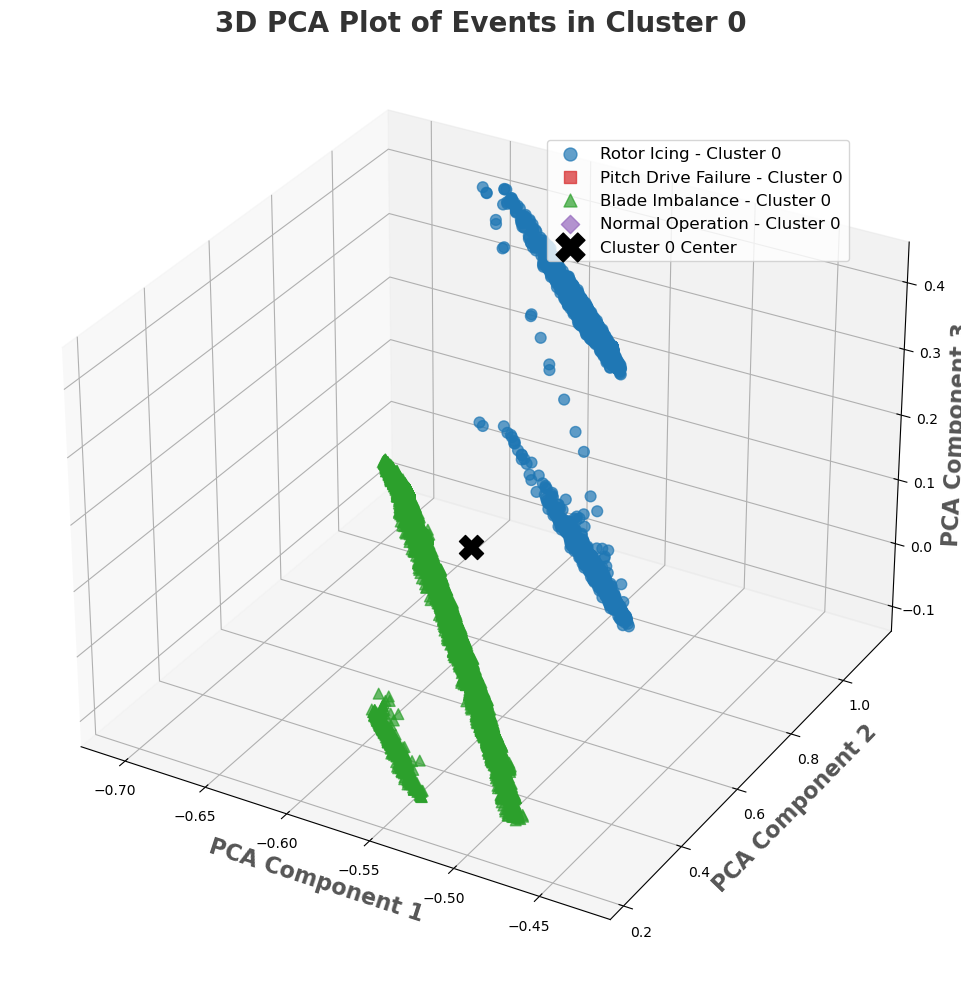

In [8]:
# Specify which cluster to plot
selected_cluster = 0  # Change this to the desired cluster number

# Plot the PCA-transformed events in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Filter data for the specific cluster
cluster_data = pca_df[pca_df['Cluster'] == selected_cluster]

# Plot each event within the selected cluster
for event, shape in zip(event_labels.keys(), cluster_shapes):
    # Filter data for the specific event within the selected cluster
    event_data = cluster_data[cluster_data['Event'] == event]

    # Use all data for better visualization
    event_data_sampled = event_data
    
    # Plot the data points for this event, within the selected cluster, with the appropriate marker and color
    ax.scatter(event_data_sampled['PCA1'], event_data_sampled['PCA2'], event_data_sampled['PCA3'],
               color=event_colors[event], marker=shape, 
               label=f"{event_labels[event]} - Cluster {selected_cluster}", s=60, alpha=0.7)  # Larger size for visibility

# Plot the selected cluster center with a distinctive marker
center = centers[selected_cluster]
ax.scatter(center[0], center[1], center[2], color='black', marker='X', s=300, label=f"Cluster {selected_cluster} Center")

# Set plot labels and title with improved styling
ax.set_title(f"3D PCA Plot of Events in Cluster {selected_cluster}", 
              fontsize=20, fontweight='bold', color='#333333', pad=-20)  # Adjust pad to reduce distance
ax.set_xlabel("PCA Component 1", fontsize=16, fontweight='bold', color='#555555')
ax.set_ylabel("PCA Component 2", fontsize=16, fontweight='bold', color='#555555')
ax.set_zlabel("PCA Component 3", fontsize=16, fontweight='bold', color='#555555')

# Refine the legend position and make it more readable
ax.legend(loc='upper right', fontsize=12, markerscale=1.2, frameon=True, bbox_to_anchor=(0.9, 0.9))

# Add a grid for better 3D visualization
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot with tight layout
plt.tight_layout()
#plt.show()
plt.savefig('m2t3/cluster0.png', dpi=300)


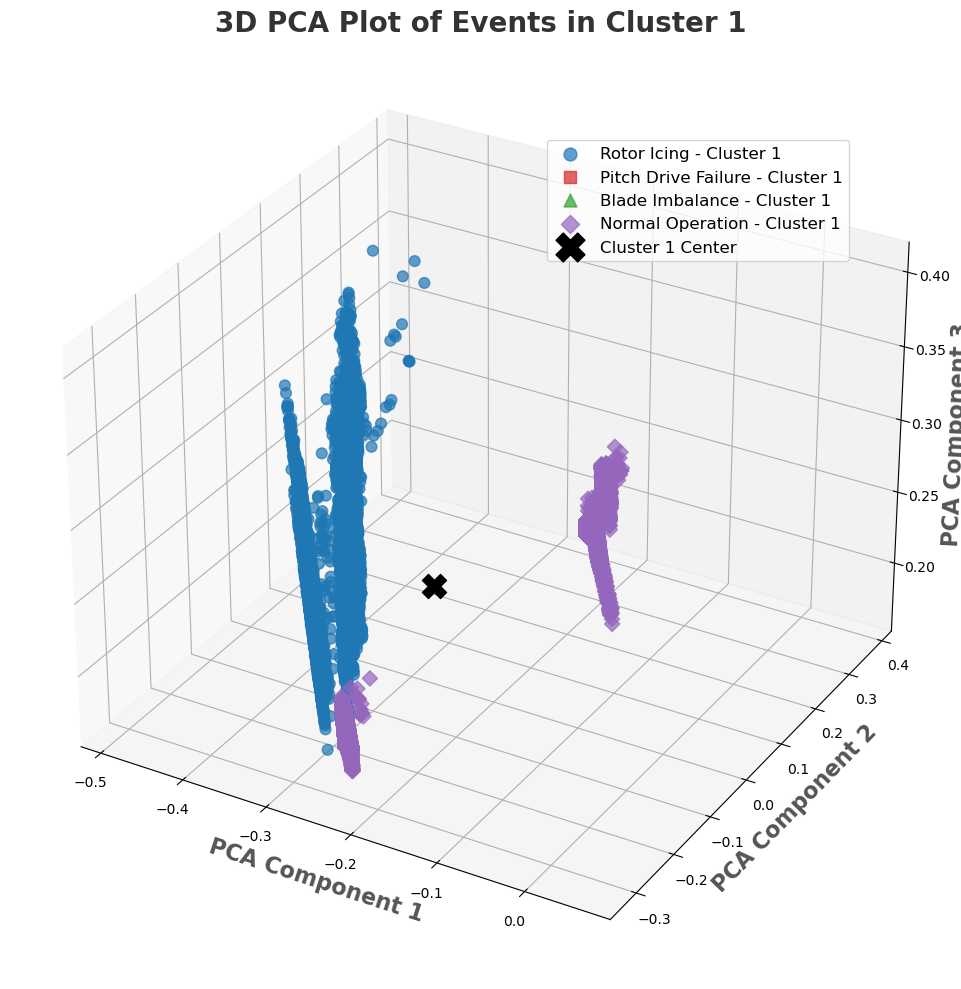

In [9]:
# Specify which cluster to plot
selected_cluster = 1

# Plot the PCA-transformed events in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Filter data for the specific cluster
cluster_data = pca_df[pca_df['Cluster'] == selected_cluster]

# Plot each event within the selected cluster
for event, shape in zip(event_labels.keys(), cluster_shapes):
    # Filter data for the specific event within the selected cluster
    event_data = cluster_data[cluster_data['Event'] == event]

    # Use all data for better visualization
    event_data_sampled = event_data
    
    # Plot the data points for this event, within the selected cluster, with the appropriate marker and color
    ax.scatter(event_data_sampled['PCA1'], event_data_sampled['PCA2'], event_data_sampled['PCA3'],
               color=event_colors[event], marker=shape, 
               label=f"{event_labels[event]} - Cluster {selected_cluster}", s=60, alpha=0.7)  # Larger size for visibility

# Plot the selected cluster center with a distinctive marker
center = centers[selected_cluster]
ax.scatter(center[0], center[1], center[2], color='black', marker='X', s=300, label=f"Cluster {selected_cluster} Center")

# Set plot labels and title with improved styling
ax.set_title(f"3D PCA Plot of Events in Cluster {selected_cluster}", 
              fontsize=20, fontweight='bold', color='#333333', pad=-20)  # Adjust pad to reduce distance
ax.set_xlabel("PCA Component 1", fontsize=16, fontweight='bold', color='#555555')
ax.set_ylabel("PCA Component 2", fontsize=16, fontweight='bold', color='#555555')
ax.set_zlabel("PCA Component 3", fontsize=16, fontweight='bold', color='#555555')

# Refine the legend position and make it more readable
ax.legend(loc='upper right', fontsize=12, markerscale=1.2, frameon=True, bbox_to_anchor=(0.9, 0.9))

# Add a grid for better 3D visualization
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot with tight layout
plt.tight_layout()
#plt.show()
plt.savefig('m2t3/cluster1.png', dpi=300)


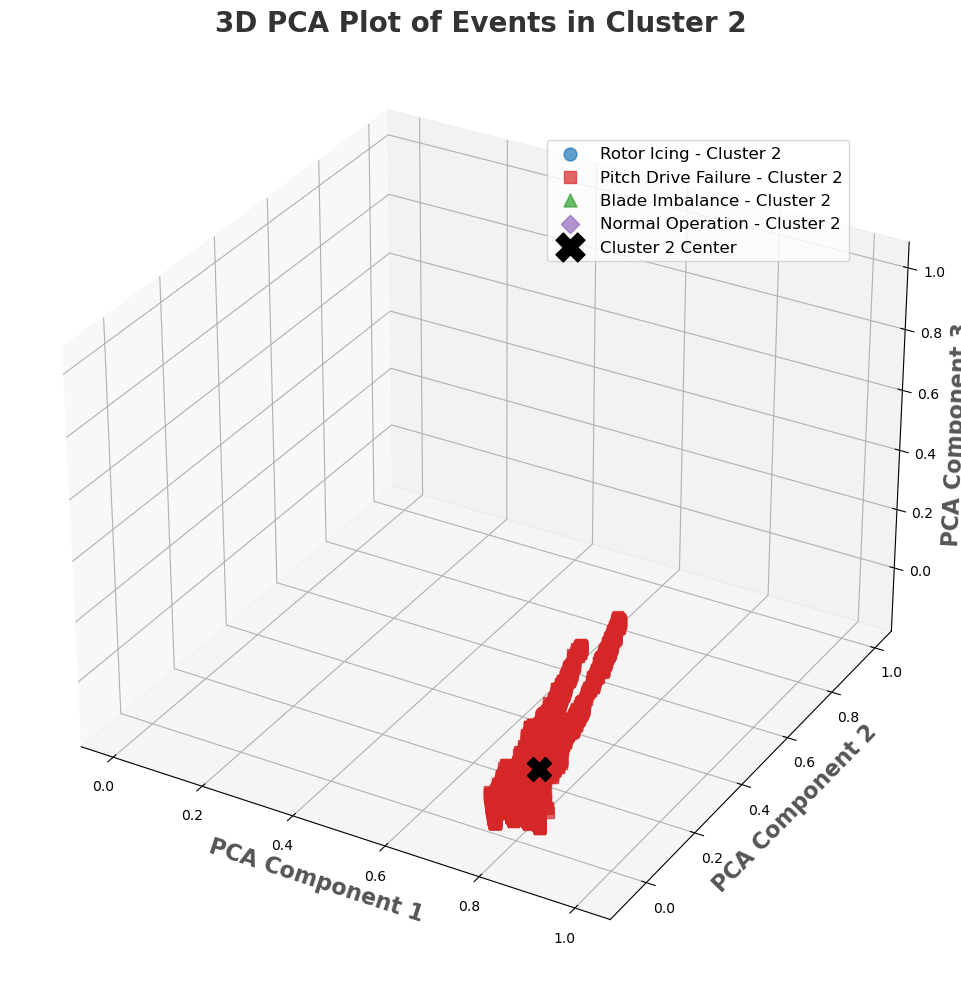

In [10]:
# Specify which cluster to plot
selected_cluster = 2

# Plot the PCA-transformed events in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Filter data for the specific cluster
cluster_data = pca_df[pca_df['Cluster'] == selected_cluster]

# Plot each event within the selected cluster
for event, shape in zip(event_labels.keys(), cluster_shapes):
    # Filter data for the specific event within the selected cluster
    event_data = cluster_data[cluster_data['Event'] == event]

    # Use all data for better visualization
    event_data_sampled = event_data
    
    # Plot the data points for this event, within the selected cluster, with the appropriate marker and color
    ax.scatter(event_data_sampled['PCA1'], event_data_sampled['PCA2'], event_data_sampled['PCA3'],
               color=event_colors[event], marker=shape, 
               label=f"{event_labels[event]} - Cluster {selected_cluster}", s=60, alpha=0.7)  # Larger size for visibility

# Plot the selected cluster center with a distinctive marker
center = centers[selected_cluster]
ax.scatter(center[0], center[1], center[2], color='black', marker='X', s=300, label=f"Cluster {selected_cluster} Center")

# Set plot labels and title with improved styling
ax.set_title(f"3D PCA Plot of Events in Cluster {selected_cluster}", 
              fontsize=20, fontweight='bold', color='#333333', pad=-20)  # Adjust pad to reduce distance
ax.set_xlabel("PCA Component 1", fontsize=16, fontweight='bold', color='#555555')
ax.set_ylabel("PCA Component 2", fontsize=16, fontweight='bold', color='#555555')
ax.set_zlabel("PCA Component 3", fontsize=16, fontweight='bold', color='#555555')

# Refine the legend position and make it more readable
ax.legend(loc='upper right', fontsize=12, markerscale=1.2, frameon=True, bbox_to_anchor=(0.9, 0.9))

# Add a grid for better 3D visualization
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot with tight layout
plt.tight_layout()
#plt.show()
plt.savefig('m2t3/cluster2.png', dpi=300)


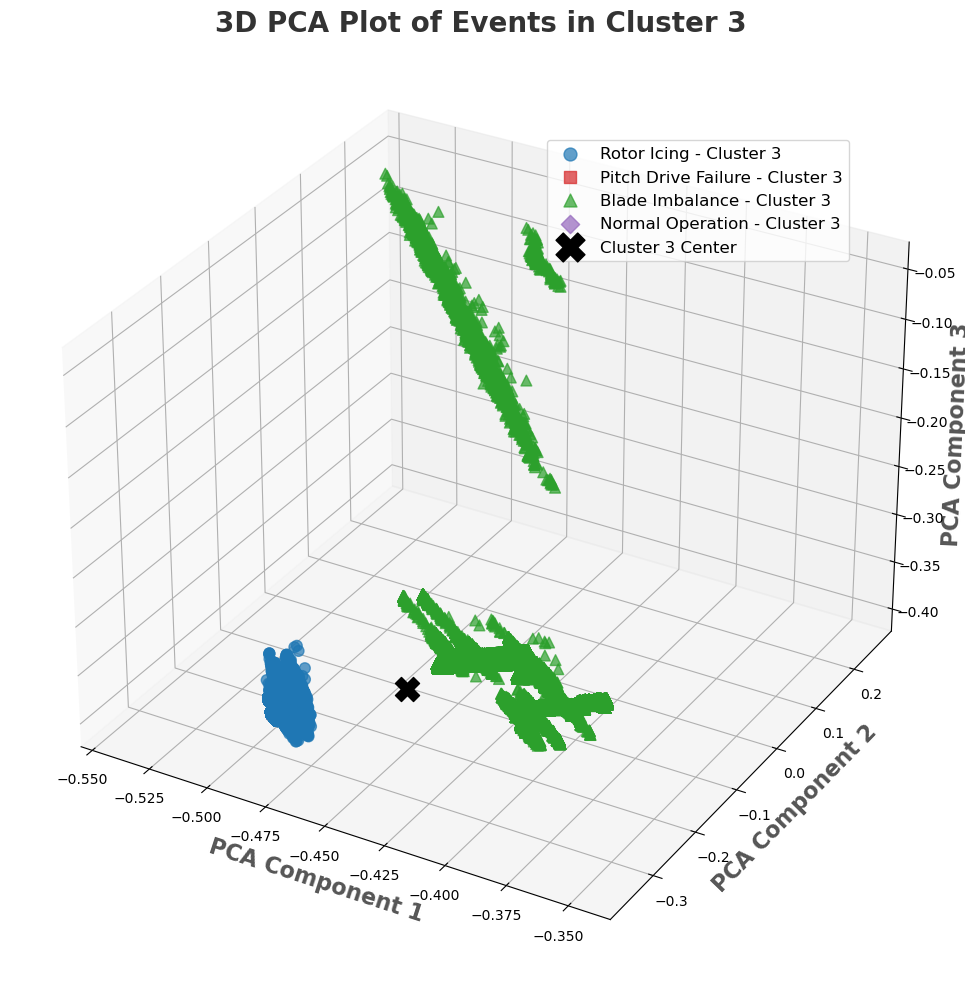

In [11]:
# Specify which cluster to plot
selected_cluster = 3  # Change this to the desired cluster number

# Plot the PCA-transformed events in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Filter data for the specific cluster
cluster_data = pca_df[pca_df['Cluster'] == selected_cluster]

# Plot each event within the selected cluster
for event, shape in zip(event_labels.keys(), cluster_shapes):
    # Filter data for the specific event within the selected cluster
    event_data = cluster_data[cluster_data['Event'] == event]

    # Use all data for better visualization
    event_data_sampled = event_data
    
    # Plot the data points for this event, within the selected cluster, with the appropriate marker and color
    ax.scatter(event_data_sampled['PCA1'], event_data_sampled['PCA2'], event_data_sampled['PCA3'],
               color=event_colors[event], marker=shape, 
               label=f"{event_labels[event]} - Cluster {selected_cluster}", s=60, alpha=0.7)  # Larger size for visibility

# Plot the selected cluster center with a distinctive marker
center = centers[selected_cluster]
ax.scatter(center[0], center[1], center[2], color='black', marker='X', s=300, label=f"Cluster {selected_cluster} Center")

# Set plot labels and title with improved styling
ax.set_title(f"3D PCA Plot of Events in Cluster {selected_cluster}", 
              fontsize=20, fontweight='bold', color='#333333', pad=-20)  # Adjust pad to reduce distance
ax.set_xlabel("PCA Component 1", fontsize=16, fontweight='bold', color='#555555')
ax.set_ylabel("PCA Component 2", fontsize=16, fontweight='bold', color='#555555')
ax.set_zlabel("PCA Component 3", fontsize=16, fontweight='bold', color='#555555')

# Refine the legend position and make it more readable
ax.legend(loc='upper right', fontsize=12, markerscale=1.2, frameon=True, bbox_to_anchor=(0.9, 0.9))

# Add a grid for better 3D visualization
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot with tight layout
plt.tight_layout()
#plt.show()
plt.savefig('m2t3/cluster3.png', dpi=300)
